In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import re
import hashlib

from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
from src.model import BaseLineModel

DATA_PATH = "./data/evaluation/"

In [40]:
df_test = pd.read_csv(f'{DATA_PATH}test.csv')
X_test = df_test.drop(columns=['strength'])
y_test = df_test['strength']


def prettify_filename(file_name):
    file_name = re.sub(r'[-_]+', ' ', file_name)
    pretty = ' '.join(word.capitalize() for word in file_name.strip().split())
    
    return pretty

files = [f for f in os.listdir(DATA_PATH) if os.path.isfile(os.path.join(DATA_PATH, f)) if not f.__contains__("test")]

data_sets = dict()

for file in files:
    file_name, file_ending = file.rsplit(".", 1)
    print(f"Reading '{file_name}'")
    file_path = DATA_PATH + file

    match file_ending:
        case "csv":
            df_train = pd.read_csv(file_path)
        case "parquet":
            df_train = pd.read_parquet(file_path)
        case _:
            raise NameError("File does not have a valid format")

    if set(df_train.columns) != set(df_test.columns):
        diffset = set(df_test.columns).difference(set(df_train.columns))
        raise AttributeError(f"faulty column{'s' if len(diffset) > 1 else ''}: {diffset}")
    

    X_train = df_train.drop(columns=['strength'])
    y_train = df_train['strength']
    del df_train
    data_sets[file_name] = {"X_train": X_train, "y_train": y_train, "name": prettify_filename(file_name)}


Reading 'lin_mix_up_1000'
Reading 'lin_mix_up_200'
Reading 'train'


In [41]:
def train_model(X_train, y_train):
    model = BaseLineModel(
        n_estimators=100, 
        random_state=76344
    )
    model.fit(X_train, y_train)
    return model

max_name_len = max([len(data['name']) for data in data_sets.values()])
pbar = tqdm(data_sets.items())

models = dict()

for _, data in pbar:
    pbar.set_description("Processing %s" % data['name'].ljust(max_name_len))
    model = train_model(data['X_train'], data['y_train'])
    y_pred = model.predict(X_test)

    # color for graph
    hash_digest = hashlib.md5(data['name'].encode('utf-8')).hexdigest()
    color = tuple(int(hash_digest[i:i+2], 16) for i in (0, 2, 4))
    color = tuple(c/255 for c in color)

    models[data['name']] = {'name': data['name'], 'color': color, 'model': model, 'y_pred': y_pred, "error": np.abs(y_test - y_pred)}


Processing Train          : 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


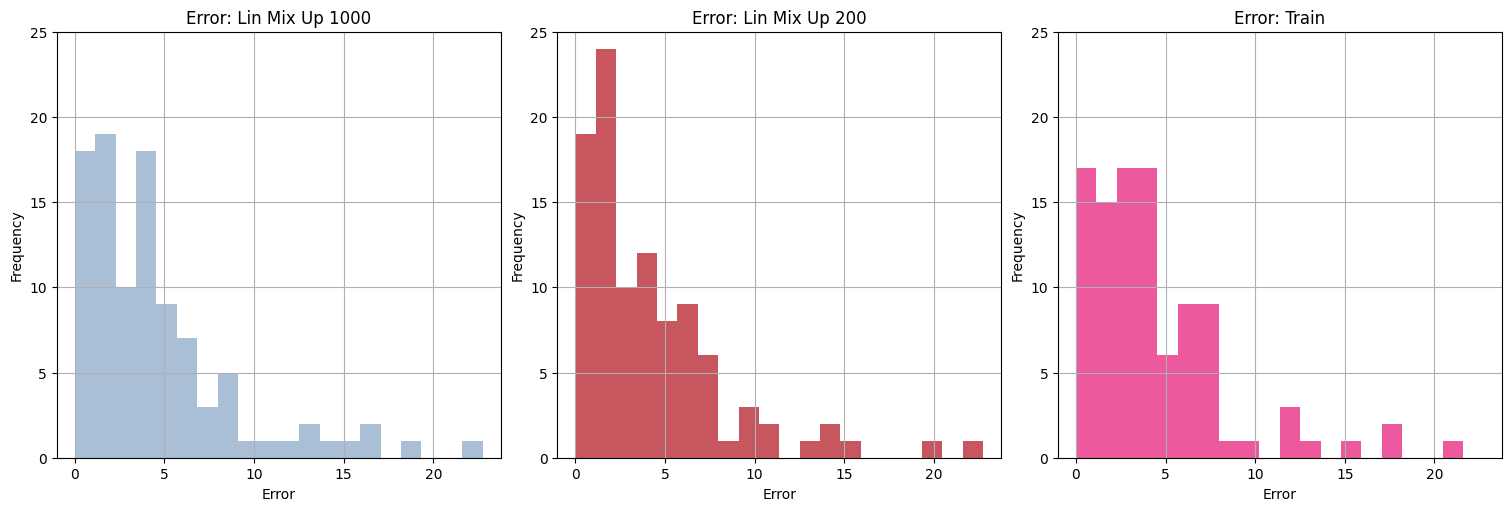

In [48]:
import matplotlib.pyplot as plt

# Number of models
model_names = list(models.keys())
num_models = len(model_names)

#
# Find the Max-Y and the X-Axis Range to make the plots comparable
#
all_errors = np.concatenate([models[name]['error'] for name in model_names])
x_min, x_max = all_errors.min(), all_errors.max()
bins = 20
max_count = 0
for name in model_names:
    counts, _ = np.histogram(models[name]['error'], bins=bins, range=(x_min, x_max))
    if counts.max() > max_count:
        max_count = counts.max()

# Create subplots: one row, multiple columns
fig, axes = plt.subplots(1, num_models, figsize=(5 * num_models, 5), constrained_layout=True)

if num_models == 1:
    axes = [axes]  # ensure axes is always iterable

for i, name in enumerate(model_names):
    ax = axes[i]
    errors = models[name]['error']
    ax.hist(errors, bins=bins, range=(x_min, x_max), alpha=0.7, color=models[name]['color'])
    ax.set_xlim(x_min - 1, x_max + 1)
    ax.set_ylim(0, max_count + 1)  # add a little padding on top
    ax.set_title(f"Error: {name}")
    ax.set_xlabel("Error")
    ax.set_ylabel("Frequency")
    ax.grid(True)

plt.show()

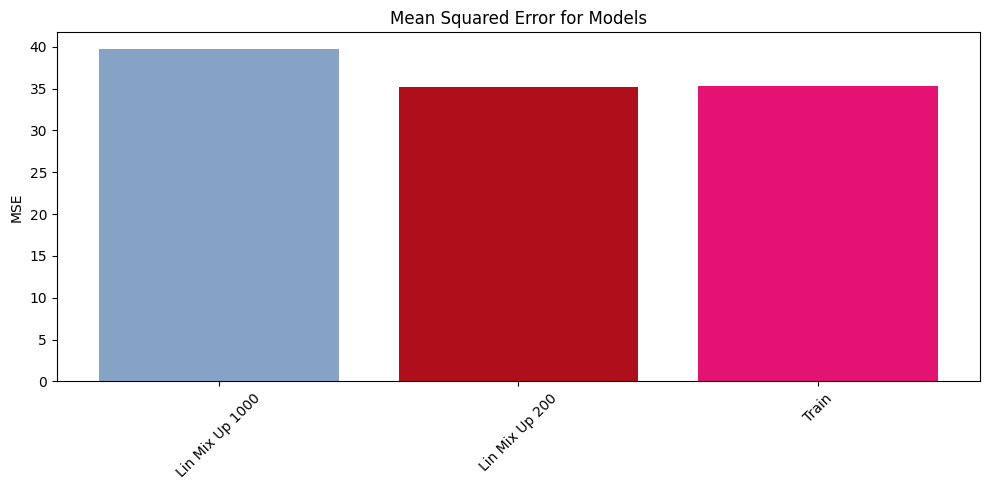

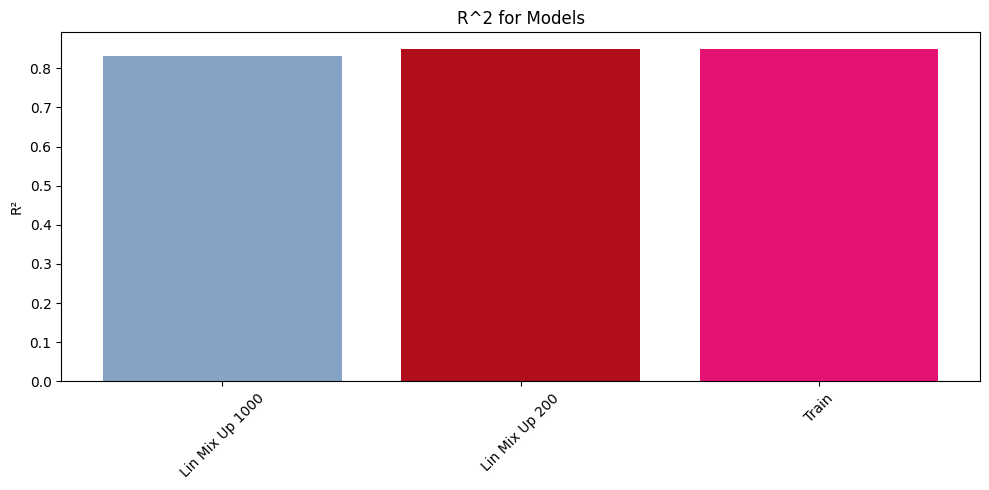

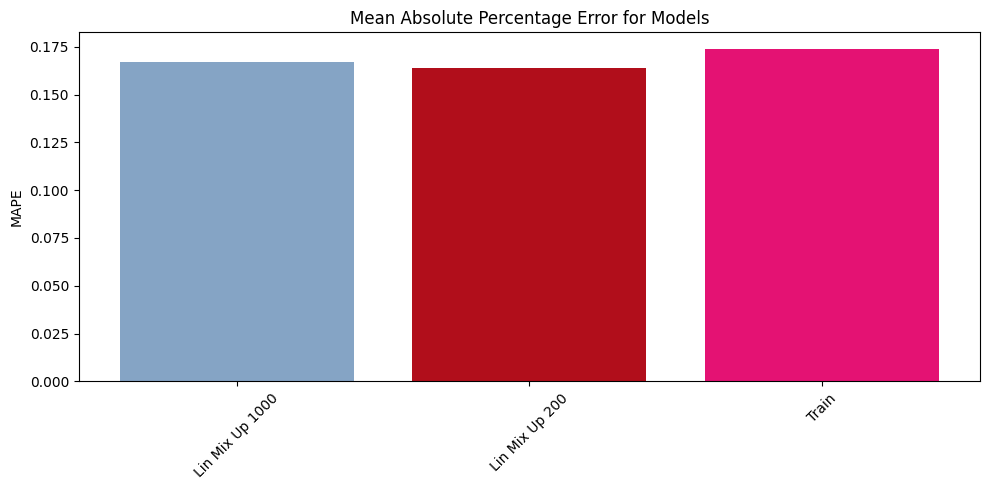

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error


single_metrics = {
    "mse": {'fn': mean_squared_error, 'name': 'Mean Squared Error', 'short': 'MSE'},
    "r2": {'fn': r2_score, 'name': 'R^2', 'short': 'R²'},
    "mape": {'fn': mean_absolute_percentage_error, 'name': 'Mean Absolute Percentage Error', 'short': 'MAPE'}
    }

for metric, values in single_metrics.items():
    model_names = []
    metrics = []
    colors = []
    for key, model in models.items():
        y_pred = model['y_pred']
        model_names.append(model['name'])
        metrics.append(values['fn'](y_test, y_pred))
        colors.append(model['color'])

    plt.figure(figsize=(10, 5))
    plt.bar(model_names, metrics, color=colors)
    plt.title(f'{values['name']} for Models')
    plt.ylabel(values['short'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [44]:
import random

# Range: 1 to 100, choose 10 unique random numbers
numbers = random.sample(range(1, 101), 20)
numbers = list(zip(numbers[::2], numbers[1::2]))
